In [2]:
## Load in the required packages

library(quantmod) 
library(tidyverse) 
library(reshape2) 
library(lubridate) 
library(glmnet)
library(ISLR) 
library(cowplot) 
library(Metrics) 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-0"><strong><em>Description</em></strong></a></span></li><li><span><a href="#Read-in-Functions" data-toc-modified-id="Read-in-Functions-1"><strong><em>Read in Functions</em></strong></a></span><ul class="toc-item"><li><span><a href="#Define-Start-and-End-Dates" data-toc-modified-id="Define-Start-and-End-Dates-1.1"><strong><em>Define Start and End Dates</em></strong></a></span></li><li><span><a href="#Normalize_Data" data-toc-modified-id="Normalize_Data-1.2"><strong><em>Normalize_Data</em></strong></a></span></li><li><span><a href="#Read_FRED_Data" data-toc-modified-id="Read_FRED_Data-1.3"><strong><em>Read_FRED_Data</em></strong></a></span></li><li><span><a href="#Read_Yahoo_Data" data-toc-modified-id="Read_Yahoo_Data-1.4"><strong><em>Read_Yahoo_Data</em></strong></a></span></li><li><span><a href="#ModelMatrix" data-toc-modified-id="ModelMatrix-1.5"><strong><em>ModelMatrix</em></strong></a></span></li><li><span><a href="#MyMSE" data-toc-modified-id="MyMSE-1.6"><strong><em>MyMSE</em></strong></a></span></li><li><span><a href="#MyRSQ" data-toc-modified-id="MyRSQ-1.7"><strong><em>MyRSQ</em></strong></a></span></li><li><span><a href="#OptimalLambda" data-toc-modified-id="OptimalLambda-1.8"><strong><em>OptimalLambda</em></strong></a></span></li></ul></li><li><span><a href="#Read-in-the-Data" data-toc-modified-id="Read-in-the-Data-2"><strong><em>Read in the Data</em></strong></a></span></li><li><span><a href="#Summarize-the-Data" data-toc-modified-id="Summarize-the-Data-3"><strong><em>Summarize the Data</em></strong></a></span></li><li><span><a href="#Create-the-Regression-Models" data-toc-modified-id="Create-the-Regression-Models-4"><strong><em>Create the Regression Models</em></strong></a></span><ul class="toc-item"><li><span><a href="#Choosing-the-Lambda-(Calibrating)" data-toc-modified-id="Choosing-the-Lambda-(Calibrating)-4.1"><strong><em>Choosing the Lambda (Calibrating)</em></strong></a></span><ul class="toc-item"><li><span><a href="#Choosing-the-Lasso-Lambda" data-toc-modified-id="Choosing-the-Lasso-Lambda-4.1.1"><strong><em>Choosing the Lasso Lambda</em></strong></a></span></li><li><span><a href="#Choosing-the-Ridge-Lambda" data-toc-modified-id="Choosing-the-Ridge-Lambda-4.1.2"><strong><em>Choosing the Ridge Lambda</em></strong></a></span></li></ul></li><li><span><a href="#Lasso-Regression" data-toc-modified-id="Lasso-Regression-4.2"><strong><em>Lasso Regression</em></strong></a></span></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-4.3"><strong><em>Ridge Regression</em></strong></a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-5"><strong><em>Results</em></strong></a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-6"><strong><em>Discussion</em></strong></a></span></li></ul></div>

## ***Description*** 

We are looking to predict the S&P 500 returns using a min of 10 features. 
*******
Start by downloading the data
******* 
Define the outcome variable as the next period return of the S&P 500 
******
Find 10 feature variables that can be used as the predictors of the S&P 500 returns 
****** 
Build a Ridge Regression and a Lasso Regression using R's glmnet package 
Calibrate the models by selecting the lambda values that minimize the out of sample MSE 
***** 
Summarize the key insights found from the two different models 


## ***Read in Functions***

We are going to begin by writing functions responsible for reading in the data 

### ***Define Start and End Dates***

Begin by defining the start and end dates we are going to use. 
This defines the training data range. 


In [3]:
train_start <- as.Date('2000-01-01') 
train_end <-  Sys.Date()

### ***Normalize_Data*** 

This function was created to normalize the data. 
Converting each value into a Z score would eliminate units of measurement that can skew correlations

In [4]:
Normalize_Data <- function(x){
    ## Normalize the data in order to remove any effects
    ## The units of measurement may have on the result 
    
    return((x - mean(x)) / sd(x) ) 
}

### ***Read_FRED_Data***
We are going to create a function that read in data from FRED

In [5]:
Read_FRED_Data <- function(start = train_start, 
                           end = train_end, ticker){
    
    ## Read in the fred data
    df <- getSymbols(ticker, src = 'FRED', auto.assign = F, from = start, 
                    to = end)  
    
    ## Find the dates and the values 
    df_dates <- index(df) 
    ## Convert data into dataframe
    data <- as_tibble(df) 
    ## Rename the columns so we can more easily handle it in tibble 
    names(data) <- c('value') 
 
    
    data <- data %>% 
        ## Add the dates to the dataframe 
        add_column(date = df_dates) %>% 
    
        ## Normalize the data in order to remove any effect different
        ## units of measurement may have on correlation
        mutate(value = Normalize_Data(value)) %>%  
    
        ## Group the data into 3 month periods 
        ## Take the first datapoint from each period 
        ## So we can see the quarterly data intervals for predictions 
        group_by(quarter = quarter(date, with_year = T) ) %>% 
        summarize(value = first(value)) %>% 
        filter(quarter > quarter(train_start, with_year = T)) 
    
    ## Rename the columns back to original ticker name and date for easy formatting 
    names(data) <- c('date', ticker) 
        
    return(data) 
    
}

### ***Read_Yahoo_Data*** 

Read in the yahoo data. Used for sp500 returns. We only want the adjusted closing prices. 

In [6]:
Read_Yahoo_Data <- function(start = train_start, 
                           to = train_end, 
                           ticker){
    
    ## Read in ticker symbols for the s&p500 data 
    data <- getSymbols(ticker, src = 'yahoo', 
                    from = train_start, to = train_end, 
                    auto.assign = F, period = 'monthly') 
    
    ## Read in the dates
    dates <- index(data) 
    
    ## Convert to a dataframe 
    df <- as_tibble(data) 
    ## Rename all the columns for easy access and add the date
    names(df) <- c('open', 'high', 'low', 'close', 'volume', 'adjusted') 
    df$date <- dates
    
    ## We only need the date and the adjusted close columns 
    df <- df[,c('date', 'adjusted')] %>% 
    
        ## Normalize the adjusted closing data 
        mutate(adjusted = Normalize_Data(adjusted) ) %>% 
        
        ## Format the date so that its broken up into quarters
        ## and then group by quarter 
        ## Taking the first value of each quarter 
        group_by(date = quarter(date, with_year = T) ) %>% 
        summarize(adjusted = first(adjusted)) %>% 
        filter(date > quarter(train_start, with_year = T)) 
        
    
    return(df)
}   



### ***ModelMatrix*** 

A function to properly format the data before it can be used in the model

In [7]:
ModelMatrix <- function(df){
 ## Format the data so it can be used in the model
    x <- model.matrix(sp500~., df)[,3:12]
    y <- df$sp500 
    
    return(list('x' = x, 'y' = y)) 
}

### ***MyMSE*** 

Find the mean squared error 

In [8]:
MyMSE <- function(pred,act){
  mse <- mean((pred-act)^2)
  return(mse)
}

### ***MyRSQ*** 

Find the R^2 value  

In [9]:
MyRSQ <- function(x, y){return(cor(x, y)^2)}

### ***OptimalLambda*** 

function to find the optimal lambda value. 

Find the mean squared errors for all the lambda values and pick the lambda with the min mean squared error

In [10]:
OptimalLambda <- function(train_x, train_y, 
                          test_x,
                          test_y, alpha){
    mse_grid <- c(NA) 
    
    grid <- 10^seq(10,-2,length=100)
    
    mse_matrix <- glmnet(train_x, train_y, 
                        alpha = alpha, 
                        lambda = grid, 
                        thresh = 1e-12) 
    
    ## Compute the mse for each model
    for(i in 1:length(grid)){
        mse_prediction <- predict(mse_matrix, 
                                 s = grid[i], 
                                 newx <- test_x) 
        mse_grid[i] <- MyMSE(mse_prediction, 
                          test_y) 
    }
    
    plot(mse_grid) 
    
    return(grid[which.min(mse_grid)])
}

## ***Read in the Data*** 

We need to find 10 different independent variables that can predict the future outcome of the S&P_500. We will combine them together in a single dataframe so we can then run the linear regressions

**** 
We are going to look at the following dependent variables: 
1. Unemployment Rate 
2. Real Personal Consumption Expenditure
3. Real Gross Domestic Product Per Capita 
4. Cash Assets, All Commercial Banks
5. Corporate Profits After Tax
6. Total Population 
7. Real Net Exports of goods and services 
8. Personal Consumption expenditures per capita
9. M2 Money Stock (M1 + time deposits) 
10. Volatility Index of S&P500 (VIX) from chicago board options exchage


In [11]:
## Read in the ticker symbols for all the fred data
fred_data <- c('UNRATE', ## unemployment rate
               'CPIAUCNS', ## consumer pricing index for all urban consumers
               'A939RX0Q048SBEA', # Real Gross Domestic Product Per Capita
               'CASACBQ158SBOG', # Cash Assets, all commercial banks
               'CP', # Corporate Profits After Tax 
               'B230RC0Q173SBEA', ## Total Population
               'NETEXC', ## Real Net Exports of goods and services
               'A794RC0Q052SBEA',  ## Personal Consumption expenditures per capita
               'M2' ## M2 Money Stock 
              )
feature_names <- c('date', 
                    'unemployment', 
                    'consumer_pricing_index', 
                    'gdp_per_capita', 
                    'cash_assets_in_commercial_banks', 
                    'corporate_profits_after_tax', 
                    'total_population', 
                    'net_exports_goods_services', 
                    'personal_consumption_expenditures_per_capita', 
                    'm2_money_stock', 
                    'VIX', 'sp500')  

In [13]:
## Create a dataframe to store all the FRED Data. Make sure the dates match up
features <- tibble(date = numeric())

for (i in fred_data){
    ## Join the dataframe to append the FRED data
    ## Match them up with the correct dates 

    
    features <- features %>% 
        full_join(Read_FRED_Data(ticker = i))
        ## rename column
    

}

## Read in sp500 data and vix
sp500 <- Read_Yahoo_Data(ticker = '^GSPC') %>% rename(sp500 = adjusted) 
vix <- Read_Yahoo_Data(ticker = '^VIX') %>% rename(vix = adjusted) 


## Add in the vix and sp500 data from Yahoo Data 
features <- features %>% full_join(vix) %>%
    full_join(sp500)  

## Rename the Data columns 
names(features) <- feature_names
## drop the null values 
features <- features %>% drop_na()
head(features) 

Joining, by = "date"
Joining, by = "date"
Joining, by = "date"
Joining, by = "date"
Joining, by = "date"
Joining, by = "date"
Joining, by = "date"
Joining, by = "date"
Joining, by = "date"
Joining, by = "date"
Joining, by = "date"


date   unemployment consumer_pricing_index gdp_per_capita
1 2000.2 -1.1531259   1.128794               0.9404985     
2 2000.3 -1.0358951   1.147679               0.9358062     
3 2000.4 -1.0945105   1.162787               0.9479768     
4 2001.1 -0.9186643   1.176636               0.9303808     
5 2001.2 -0.8014335   1.199297               0.9422581     
6 2001.3 -0.6842027   1.206851               0.9191633     
  cash_assets_in_commercial_banks corporate_profits_after_tax total_population
1 -0.11482788                      0.018749563                0.7880232       
2 -0.40675930                      0.008336457                0.8019429       
3 -0.31773057                     -0.026018958                0.8155360       
4 -0.04443307                      0.033178902                0.8273506       
5 -0.42953409                      0.069708711                0.8394918       
6  0.43383756                     -0.003955261                0.8530304       
  net_exports_goods_services personal_consumption_expenditures_per_capita
1 -0.5397744                 0.6628294                                   
2 -0.6450971                 0.6861359                                   
3 -0.6818328                 0.7065750                                   
4 -0.6470369                 0.7217940                                   
5 -0.6020204                 0.7303226                                   
6 -0.6885395                 0.7328958                                   
  m2_money_stock VIX         sp500     
1 -0.4123912      0.45384824 -0.2287531
2 -0.4031681     -0.01648539 -0.2816918
3 -0.3822369      0.14029245 -0.3300967
4 -0.3599438      1.12127377 -0.5523727
5 -0.3248912      1.25789435 -0.7520374
6 -0.3055131     -0.13630845 -0.6200175

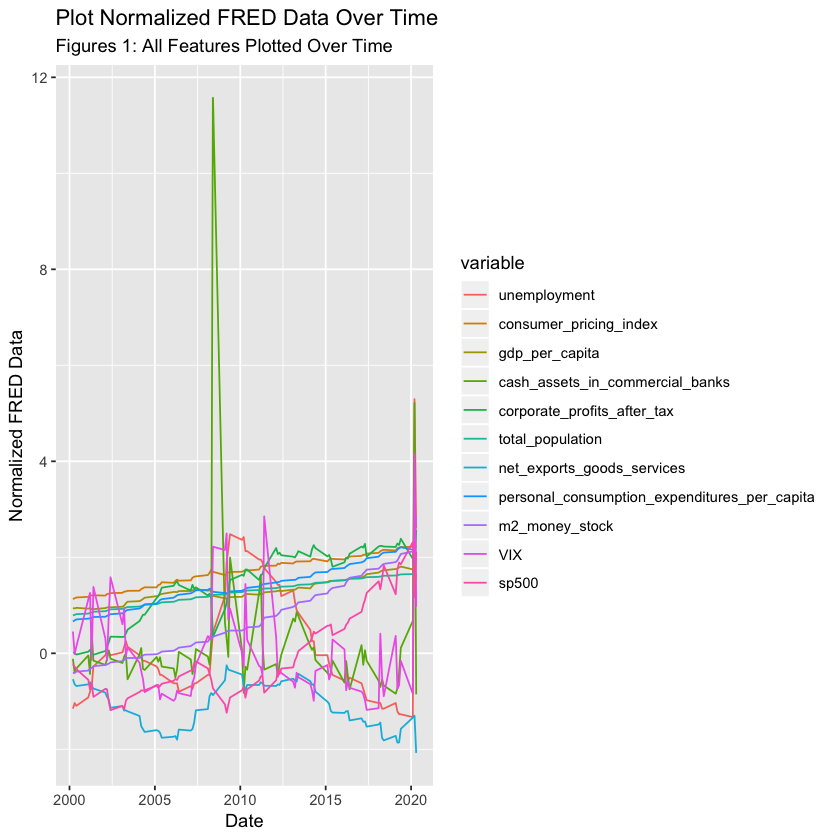

In [14]:
## Plot Features Data 
dependent_features_plot <- ggplot(data = melt(features, id = c('date')), 
       aes(x = date, y = value, col = variable)) + 

        geom_line()  + 

        labs(x = 'Date', y = 'Normalized FRED Data', 
            colours = 'Variables', 
            title = 'Plot Normalized FRED Data Over Time', 
        subtitle = 'Figures 1: All Features Plotted Over Time') 

dependent_features_plot


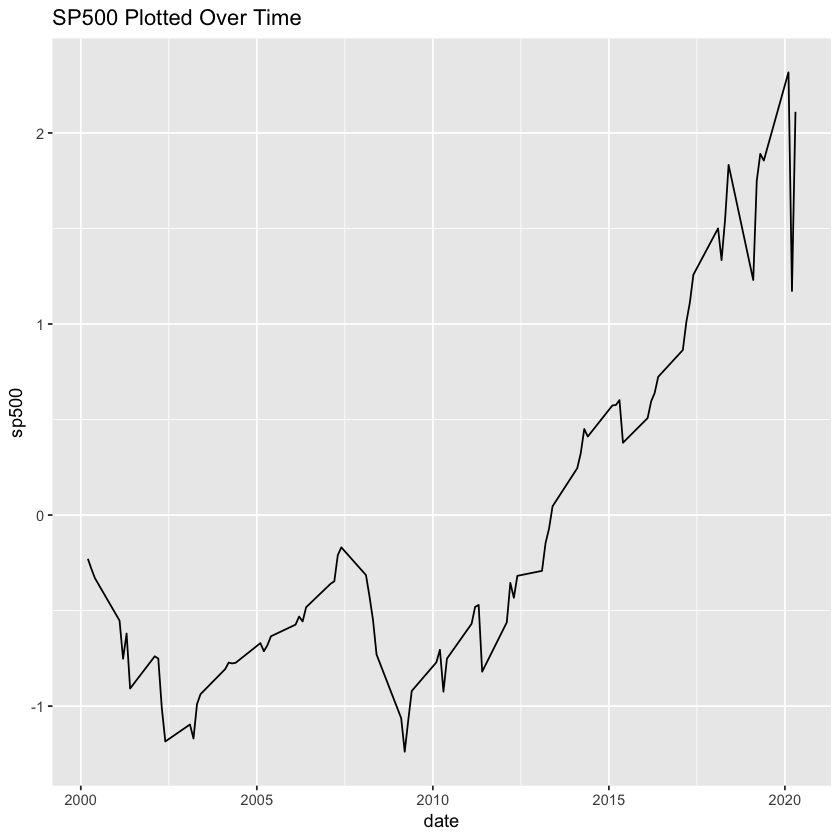

In [15]:
ggplot(data = features, aes(x = date, 
                           y = sp500)) + geom_line() + 
labs(title = 'SP500 Plotted Over Time')

## ***Summarize the Data*** 

Now we have all the data we need we can summarize it (create the summary statistics) 

In [16]:
summary <- tibble(names = names(features), 
            std = sapply(features, sd), 
            mean = sapply(features, mean), 
            min = sapply(features, min), 
            max = sapply(features, max), 
             p.25 = 1, 
             p.50 = 1, 
             p.75 = 1)

v1 <- c(0.25,0.50,0.75)
summary[,c(6:8)] <- t(sapply(features, function(x) quantile(x,probs = v1)))

## Remove date
summary <- summary[-1,]
summary

names                                        std       mean       
1  unemployment                                 1.2324390  0.15785745
2  consumer_pricing_index                       0.3276025  1.70598926
3  gdp_per_capita                               0.2438614  1.30712897
4  cash_assets_in_commercial_banks              1.4938156  0.11958583
5  corporate_profits_after_tax                  0.7557202  1.43583656
6  total_population                             0.2638900  1.26574322
7  net_exports_goods_services                   0.4636360 -1.09284668
8  personal_consumption_expenditures_per_capita 0.4367802  1.39982197
9  m2_money_stock                               0.8016129  0.69662549
10 VIX                                          0.9838952 -0.01543383
11 sp500                                        0.9068680 -0.06998955
   min         max        p.25          p.50       p.75       
1  -1.32897210  5.2945676 -0.6695488962 -0.1859719  0.88375909
2   1.12879393  2.2342012  1.4246569718  1.7212880  1.96522708
3   0.91916326  1.8071784  1.1500750699  1.2946928  1.49842234
4  -0.85397339 11.5727812 -0.3839845066 -0.1531309  0.08445155
5  -0.02978737  2.5753326  0.9502640916  1.6227884  2.05258601
6   0.78802321  1.6657837  1.0379978266  1.2918017  1.49664609
7  -2.07504892 -0.2504139 -1.5095908993 -1.1488013 -0.65619856
8   0.66282938  2.2104675  1.0806181437  1.3445254  1.74365791
9  -0.41239123  2.8357430 -0.0002008239  0.4986175  1.32836848
10 -1.17888106  4.1526853 -0.7029483412 -0.3222022  0.35194250
11 -1.23854218  2.3170161 -0.7481101864 -0.3923502  0.55718341

## ***Create the Regression Models*** 

Start by splitting up the data into test and train data 
We are going to predict data after 2018 by using data scraped from before 2018. 

In [17]:

## We will split the test and train data up by 2018. 
## Data before this point is the training data 
## Data after this point is the testing data
split_point <- quarter('2018-01-01', 
                                 with_year = T)
test <- subset.data.frame(features, 
                  date >= split_point) 

train <- subset.data.frame(features, 
                          date < split_point)



train <- ModelMatrix(train) 
test <- ModelMatrix(test) 

## Split the data into test and train, 
## properly formatted
train_x <- train$x
train_y <- train$y 
test_x <- test$x 
test_y <- test$y

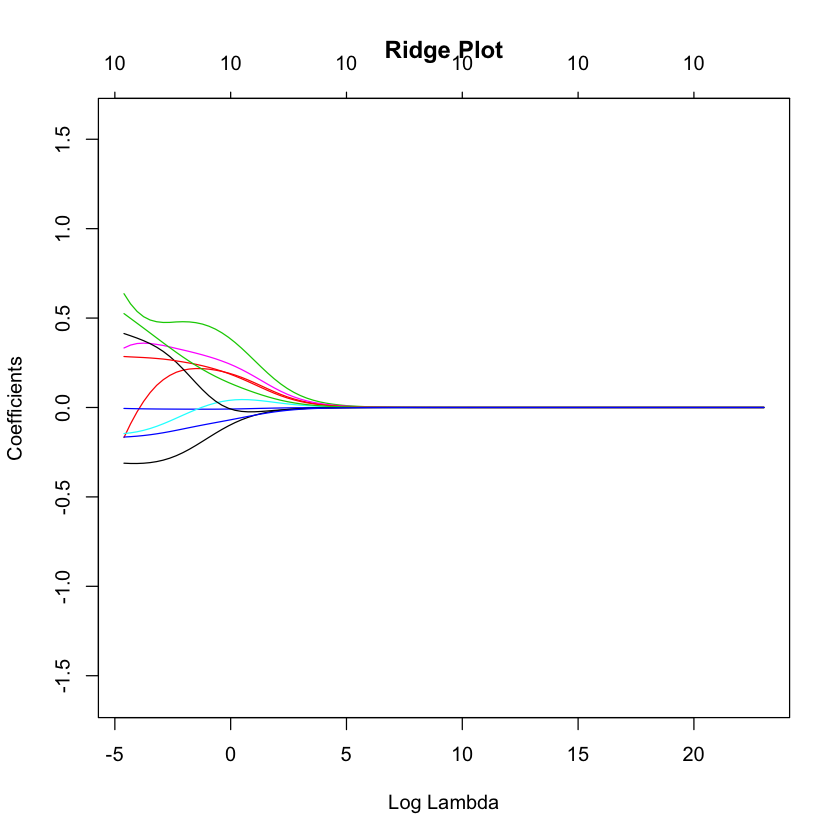

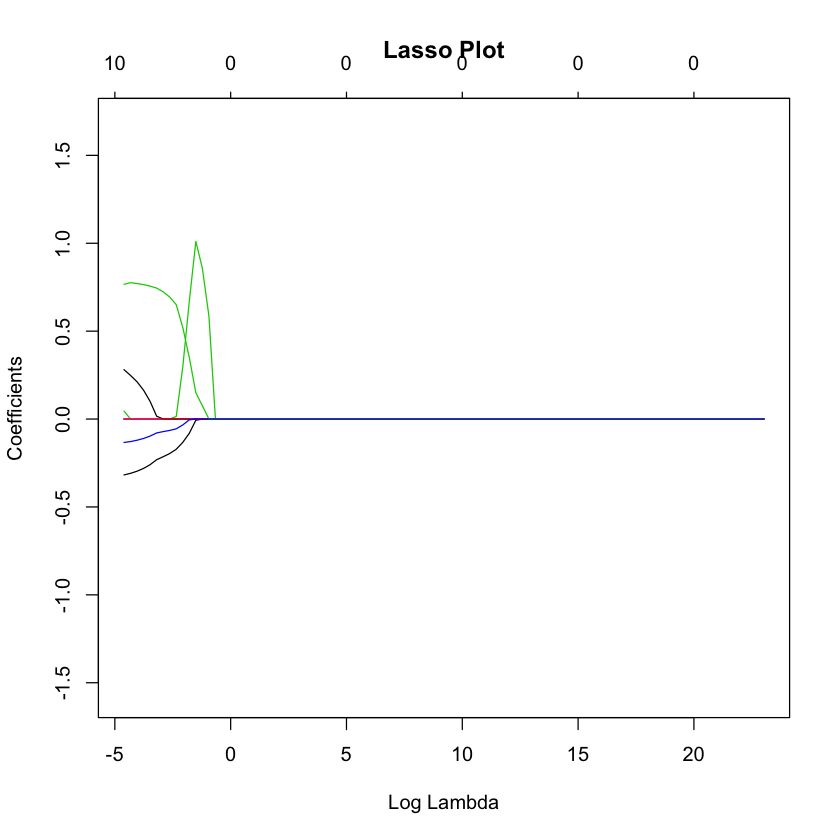

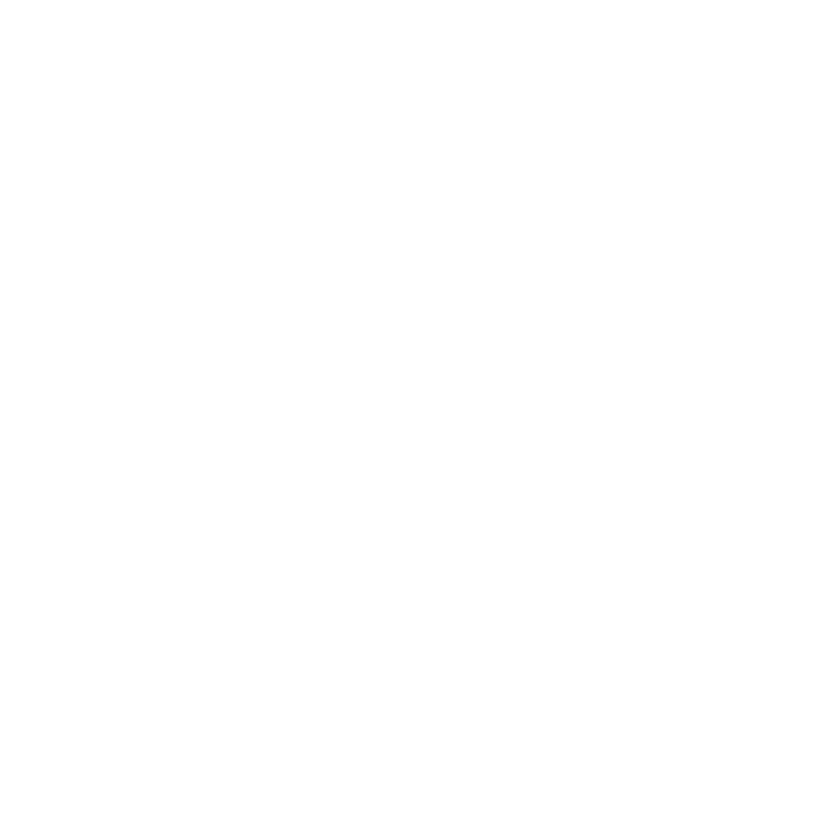

In [18]:
## Regression 
grid <- c(10^seq(10, -2, length = 99), 0) 

# Ridge Model 
ridge_model <- glmnet(train_x, train_y, 
                      alpha = 0, ## 0 for ridge regression
                     lambda = grid, 
                     standardize = T) 

# Lasso Model
lasso_model <- glmnet(train_x, train_y, alpha = 1, 
                     lambda = grid, 
                     standardize = T) 

## Plot the ridge and lasso lambda values 
ridge_plot <- plot(ridge_model, 
                   xvar = 'lambda', label = T, 
                  main = 'Ridge Plot')  
lasso_plot <- plot(lasso_model, 
                  xvar = 'lambda', label = T, 
                  main = 'Lasso Plot')  

plot_grid(ridge_plot, lasso_plot) 



### ***Choosing the Lambda (Calibrating)***

#### ***Choosing the Lasso Lambda***

[1] "Optimal value of lambda for lasso is 0.040"

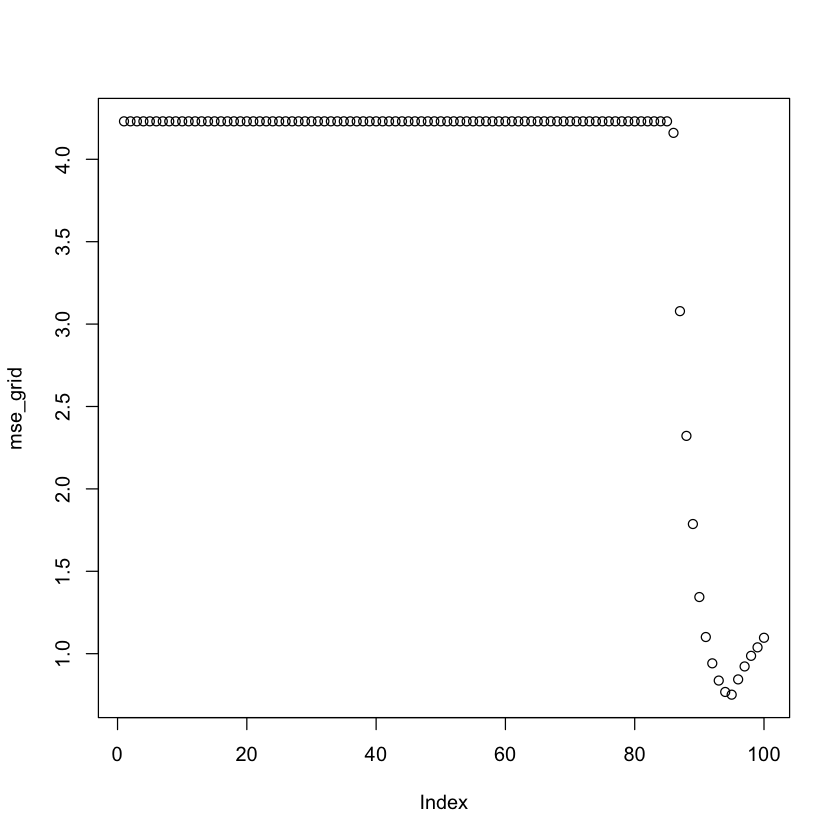

In [19]:
lasso_lambda <- OptimalLambda(train_x, train_y,
                              test_x,
                              test_y,
                             1)
sprintf(
    "Optimal value of lambda for lasso is %.3f",
    lasso_lambda) 




#### ***Choosing the Ridge Lambda***

[1] "Optimal value of lambda for ridge is 0.285"

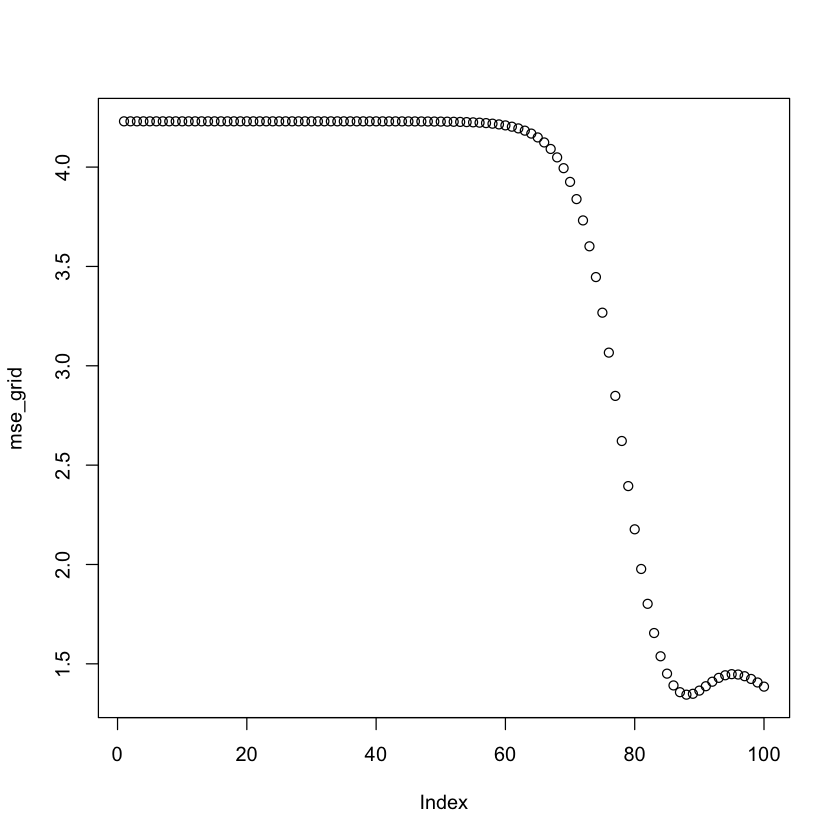

In [20]:
ridge_lambda <- OptimalLambda(train_x, 
                              train_y,
                              test_x, 
                              test_y,
                             0) 

sprintf(
    "Optimal value of lambda for ridge is %.3f",
    ridge_lambda) 

### ***Lasso Regression***

In [21]:
lasso_predict <- glmnet(train_x, (train_y), 
                        alpha = 1, 
                        lambda = grid, 
                        thresh = 1e-12) 


lasso_prediction <- predict(lasso_predict, 
                     s = lasso_lambda, 
                     newx <- test_x) 


print(lasso_predict$beta[,c(1:2,99:100)],
      digits=4)


10 x 4 sparse Matrix of class "dgCMatrix"
                                             s0 s1        s98      s99
unemployment                                  .  .   -0.31798 -0.20572
consumer_pricing_index                        .  . .          -1.40495
gdp_per_capita                                .  .    0.05816  1.77995
cash_assets_in_commercial_banks               .  . .           0.01427
corporate_profits_after_tax                   .  . .          -0.08090
total_population                              .  . .          -2.15933
net_exports_goods_services                    .  .    0.28288  0.58946
personal_consumption_expenditures_per_capita  .  . .           1.31764
m2_money_stock                                .  .    0.76277  1.00001
VIX                                           .  .   -0.13304 -0.15886


### ***Ridge Regression***

In [22]:
ridge_predict <- glmnet(train_x, train_y, 
                       alpha = 0, 
                       lambda = grid, 
                       thresh = 1e-12) 

ridge_prediction <- predict(ridge_predict, 
                           s = ridge_lambda, 
                           newx <- test_x) 

print(ridge_predict$beta[,c(1:2,99:100)],
      digits=4)

10 x 4 sparse Matrix of class "dgCMatrix"
                                                     s0         s1       s98
unemployment                                 -1.352e-11 -1.792e-11 -0.310514
consumer_pricing_index                        9.085e-11  1.204e-10 -0.170567
gdp_per_capita                                1.573e-10  2.085e-10  0.657539
cash_assets_in_commercial_banks              -2.954e-12 -3.916e-12 -0.005054
corporate_profits_after_tax                   3.192e-11  4.232e-11 -0.143730
total_population                              1.125e-10  1.492e-10  0.310932
net_exports_goods_services                   -1.543e-11 -2.046e-11  0.414375
personal_consumption_expenditures_per_capita  8.000e-11  1.061e-10  0.273501
m2_money_stock                                4.801e-11  6.365e-11  0.532344
VIX                                          -2.267e-11 -3.005e-11 -0.164893
                                                  s99
unemployment                                 -0.20575
con

## ***Results*** 

In [23]:
regression <- tibble(test_y) %>% 
        add_column(
            lasso_prediction = lasso_prediction) %>%

       add_column(
           ridge_prediction = ridge_prediction) 


lasso_mse <- MyMSE(regression$test_y, 
                  regression$lasso_prediction) 
ridge_mse <- MyMSE(regression$test_y, 
                  regression$ridge_prediction) 

sprintf(
    "The MSE for the lasso regression was %.3f",
    lasso_mse) 
sprintf(
    "The MSE for the ridge regression was %.3f",
    ridge_mse) 

[1] "The MSE for the lasso regression was 0.751"

[1] "The MSE for the ridge regression was 1.345"

In [24]:
lasso_rsq <- MyRSQ(regression$test_y, 
                  regression$lasso_prediction)

ridge_rsq <- MyRSQ(regression$test_y, 
                  regression$ridge_prediction)

sprintf(
    "The R^2 for the lasso regression was %.3f",
    lasso_rsq) 
sprintf(
    "The R^2 for the ridge regression was %.3f",
    ridge_rsq) 

[1] "The R^2 for the lasso regression was 0.317"

[1] "The R^2 for the ridge regression was 0.180"

## ***Discussion*** 


It can be seen that the lasso regression works the best, with a R^2 of 0.317 while the R^2 for the ridge regression was 0.180. Both of these regression functions are great because they are variants of a linear regression model but with penalty functions added on. The Ridge regression does this by adding a "loss penalty function" which shrinks the coefficient values towards zero. This is done to allow variables that aren't as contributive to have a coefficient closer to zero. 

Unfortunately the drawback to this is that the coefficients is never going to be 0. This isn't necessarily bad, but it does make results more difficult to interpret when there are more predictors. The lasso regression allows us to zero out coefficients, allowing for an automatic variable selection. So because in this model we had more than a few features (10) the lasso regression ends up working the best. 

From the Sparse Matrix of Coefficients (Lasso Regression) it can be seen that not a lot of the variables have much of a correlation with the final result. The exceptions to this are the M2 Money Stock, consumption expenditures, and GDP per capita. Consumer Pricing Index and the total population seem to be strongly negatively correlated. The rest of the features are pulled closer to zero, meaning they most likely don't have much of an impact on the final outcome. 
